In [70]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.covariance import MinCovDet
from sklearn.decomposition import PCA
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from scipy.stats import multivariate_normal
from pyod.models.lof import LOF
from sklearn.neighbors import NearestNeighbors

# Generate random data
np.random.seed(42)
n_samples = 100
data = pd.DataFrame({
    'maturity_value': np.random.choice([0, 100], n_samples),
    'category': np.random.choice(['S.A', 'I.T', 'A', 'B'], n_samples),
    'currency': np.random.choice(['USD', 'EUR', 'GBP'], n_samples),
    'amount': np.random.choice([100, 1000], n_samples),
})


# Encode categorical variables
categorical_vars = ['category', 'currency']
for var in categorical_vars:
    data[var] = data[var].astype('category').cat.codes

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data)

data.head()

,maturity_value,category,currency,amount
0,0,0,1,1000
1,100,2,1,1000
2,0,2,2,100
3,0,1,2,1000
4,0,2,0,100


In [74]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import KernelPCA
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

# Encode categorical variables
label_encoders = {}
categorical_vars = ['category', 'currency']
for var in categorical_vars:
    le = LabelEncoder()
    data[var] = le.fit_transform(data[var])
    label_encoders[var] = le

# Aggregation Features
data['mean_amount'] = data.groupby('category')['amount'].transform('mean')
data['std_amount'] = data.groupby('currency')['amount'].transform('std')

# Interaction Features
# data['interaction_1'] = data['maturity_value'] * data['amount']
# data['interaction_2'] = data['category'] + data['currency']

# Distance-Based Features
X = data[['maturity_value', 'category', 'currency', 'amount']]
distances = NearestNeighbors(n_neighbors=5).fit(X).kneighbors(X)[0]
data['mean_distance'] = distances.mean(axis=1)

# Clustering Features
kmeans = KMeans(n_clusters=3, random_state=42)
data['cluster'] = kmeans.fit_predict(X)

# LOF Features
X_scaled = StandardScaler().fit_transform(X)
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
data['lof_score'] = -lof.fit_predict(X_scaled)


# PCA Features
n_components = 2
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)
pca_columns = [f'PCA_{i+1}' for i in range(n_components)]
data[pca_columns] = X_pca

# Cosine Similarity Features
cosine_sim = cosine_similarity(X_scaled)
data['avg_cosine_similarity'] = cosine_sim.mean(axis=1)

# Apply Kernel PCA with RBF kernel
kpca = KernelPCA(n_components=2, kernel='rbf')
X_kpca = kpca.fit_transform(X_scaled)
pca_columns = [f'KPCA_{i+1}' for i in range(n_components)]
data[pca_columns] = X_kpca


# Build and train an autoencoder
input_layer = Input(shape=(4,))
encoded = Dense(2, activation='relu')(input_layer)
decoded = Dense(4, activation='sigmoid')(encoded)
autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(X_scaled, X_scaled, epochs=50, batch_size=16)

# Extract encoded features
encoded_features = autoencoder.predict(X_scaled)
# Create a DataFrame with encoded features
encoded_columns = [f'encoded_{i+1}' for i in range(encoded_features.shape[1])]
encoded_df = pd.DataFrame(encoded_features, columns=encoded_columns)

# Combine encoded features with original data
data = pd.concat([data, encoded_df], axis=1)

# Display the updated dataframe
print(data)

C:\Users\pixel\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\pixel\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Epoch 1/50
7/7 [==============================] - 1s 4ms/step - loss: 1.2337
Epoch 2/50
7/7 [==============================] - 0s 3ms/step - loss: 1.2285
Epoch 3/50
7/7 [==============================] - 0s 3ms/step - loss: 1.2234
Epoch 4/50
7/7 [==============================] - 0s 3ms/step - loss: 1.2183
Epoch 5/50
7/7 [==============================] - 0s 4ms/step - loss: 1.2135
Epoch 6/50
7/7 [==============================] - 0s 3ms/step - loss: 1.2088
Epoch 7/50
7/7 [==============================] - 0s 3ms/step - loss: 1.2043
Epoch 8/50
7/7 [==============================] - 0s 3ms/step - loss: 1.1997
Epoch 9/50
7/7 [==============================] - 0s 2ms/step - loss: 1.1950
Epoch 10/50
7/7 [==============================] - 0s 3ms/step - loss: 1.1906
Epoch 11/50
7/7 [==============================] - 0s 3ms/step - loss: 1.1857
Epoch 12/50
7/7 [==============================] - 0s 3ms/step - loss: 1.1814
Epoch 13/50
7/7 [==============================] - 0s 2ms/step - loss: 1.

In [75]:
from scipy.stats import skew, kurtosis

# Calculate skewness and kurtosis for each instance
data['skewness'] = data.apply(skew, axis=1)
data['kurtosis'] = data.apply(kurtosis, axis=1)

data.head()

,maturity_value,category,currency,amount,mean_amount,std_amount,mean_distance,cluster,lof_score,PCA_1,PCA_2,avg_cosine_similarity,KPCA_1,KPCA_2,encoded_1,encoded_2,encoded_3,encoded_4,skewness,kurtosis
0,0,0,1,1000,520.0,446.577897,0.6,2,-1,0.151591,-1.185664,0.014262,-0.143109,-0.428460,0.396913,0.134461,0.302062,0.286205,2.398885,5.198947
1,100,2,1,1000,595.0,446.577897,0.4,1,-1,-0.493104,-0.429581,0.030524,0.429812,-0.209809,0.425564,0.447661,0.425176,0.446665,2.277038,4.490918
2,0,2,2,100,595.0,450.000000,0.4,0,-1,1.743917,0.605338,-0.031312,-0.582764,0.159559,0.434489,0.461754,0.451105,0.397237,2.494798,5.067433
3,0,1,2,1000,850.0,450.000000,0.0,2,-1,1.225331,-1.346222,0.010112,-0.350554,-0.565764,0.425564,0.447661,0.425176,0.446665,2.123232,3.268658
4,0,2,0,100,595.0,457.200457,0.8,0,-1,0.343560,1.691850,-0.030709,-0.288498,0.345429,0.486083,0.384452,0.579456,0.102524,2.484996,4.993589


In [77]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from networkx import Graph, degree_centrality, clustering

# Create a graph from clusters
G = Graph()
G.add_nodes_from(data.index)
for cluster in data['cluster'].unique():
    nodes = data[data['cluster'] == cluster].index
    G.add_edges_from([(n1, n2) for n1 in nodes for n2 in nodes if n1 != n2])

# Calculate degree centrality and clustering coefficient for each instance
data['degree_centrality'] = data.index.map(degree_centrality(G))
data['clustering_coefficient'] = data.index.map(clustering(G))

# Display the updated dataframe
print(data)

    maturity_value  category  currency  amount  mean_amount  std_amount  \
0                0         0         1    1000   520.000000  446.577897   
1              100         2         1    1000   595.000000  446.577897   
2                0         2         2     100   595.000000  450.000000   
3                0         1         2    1000   850.000000  450.000000   
4                0         2         0     100   595.000000  457.200457   
..             ...       ...       ...     ...          ...         ...   
95             100         2         2    1000   595.000000  450.000000   
96             100         2         1    1000   595.000000  446.577897   
97             100         1         0    1000   850.000000  457.200457   
98             100         3         2    1000   515.384615  450.000000   
99               0         0         1    1000   520.000000  446.577897   

    mean_distance  cluster  lof_score     PCA_1  ...    KPCA_1    KPCA_2  \
0             0.6      

In [79]:
# Dissimilarity to Neighbors Feature
from sklearn.metrics.pairwise import pairwise_distances
dist_matrix = pairwise_distances(X_scaled, metric='mahalanobis')
data['dissimilarity_to_neighbors'] = np.mean(dist_matrix, axis=1)
print(data.head())

   maturity_value  category  currency  amount  mean_amount  std_amount  \
0               0         0         1    1000        520.0  446.577897   
1             100         2         1    1000        595.0  446.577897   
2               0         2         2     100        595.0  450.000000   
3               0         1         2    1000        850.0  450.000000   
4               0         2         0     100        595.0  457.200457   

   mean_distance  cluster  lof_score     PCA_1  ...    KPCA_2  encoded_1  \
0            0.6        2         -1  0.151591  ... -0.428460   0.396913   
1            0.4        1         -1 -0.493104  ... -0.209809   0.425564   
2            0.4        0         -1  1.743917  ...  0.159559   0.434489   
3            0.0        2         -1  1.225331  ... -0.565764   0.425564   
4            0.8        0         -1  0.343560  ...  0.345429   0.486083   

   encoded_2  encoded_3  encoded_4  skewness  kurtosis  degree_centrality  \
0   0.134461   0.3020

In [81]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import silhouette_samples
from sklearn.svm import OneClassSVM

# Proximity to Decision Boundaries Feature
oneclass_svm = OneClassSVM(nu=0.1)
oneclass_svm.fit(X_scaled)
data['svm_distance'] = oneclass_svm.decision_function(X_scaled)
print(data.head())

   maturity_value  category  currency  amount  mean_amount  std_amount  \
0               0         0         1    1000        520.0  446.577897   
1             100         2         1    1000        595.0  446.577897   
2               0         2         2     100        595.0  450.000000   
3               0         1         2    1000        850.0  450.000000   
4               0         2         0     100        595.0  457.200457   

   mean_distance  cluster  lof_score     PCA_1  ...  encoded_1  encoded_2  \
0            0.6        2         -1  0.151591  ...   0.396913   0.134461   
1            0.4        1         -1 -0.493104  ...   0.425564   0.447661   
2            0.4        0         -1  1.743917  ...   0.434489   0.461754   
3            0.0        2         -1  1.225331  ...   0.425564   0.447661   
4            0.8        0         -1  0.343560  ...   0.486083   0.384452   

   encoded_3  encoded_4  skewness  kurtosis  degree_centrality  \
0   0.302062   0.286205  2

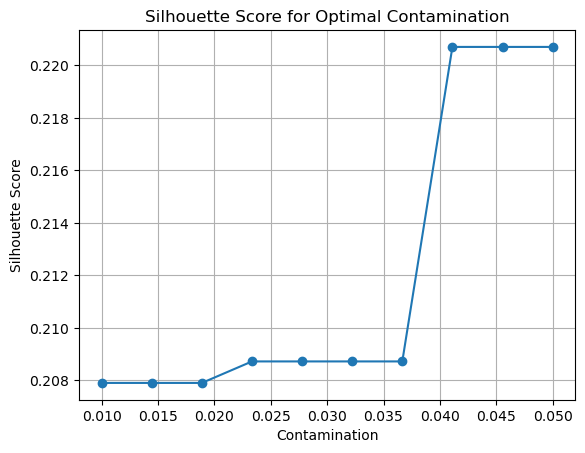

Optimal Contamination: 0.04
    maturity_value  category  currency  amount  mean_amount  std_amount  \
0                0         0         1    1000   520.000000  446.577897   
1              100         2         1    1000   595.000000  446.577897   
2                0         2         2     100   595.000000  450.000000   
3                0         1         2    1000   850.000000  450.000000   
4                0         2         0     100   595.000000  457.200457   
..             ...       ...       ...     ...          ...         ...   
95             100         2         2    1000   595.000000  450.000000   
96             100         2         1    1000   595.000000  446.577897   
97             100         1         0    1000   850.000000  457.200457   
98             100         3         2    1000   515.384615  450.000000   
99               0         0         1    1000   520.000000  446.577897   

    mean_distance  cluster  lof_score     PCA_1  ...  encoded_2  encode

In [85]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data)

# Range of contamination values to try
contamination_values = np.linspace(0.01, 0.05, 10)

# Evaluate different contamination values using silhouette score
silhouette_scores = []
for contamination in contamination_values:
    iso_forest = IsolationForest(contamination=contamination, random_state=42)
    iso_forest.fit(X_scaled)
    labels = iso_forest.predict(X_scaled)
    silhouette_scores.append(silhouette_score(X_scaled, labels))

# Plot the silhouette scores to determine the optimal contamination value
plt.plot(contamination_values, silhouette_scores, marker='o')
plt.xlabel('Contamination')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal Contamination')
plt.grid()
plt.show()

# Choose the optimal contamination value that maximizes the silhouette score
optimal_contamination = contamination_values[np.argmax(silhouette_scores)]
print(f'Optimal Contamination: {optimal_contamination:.2f}')

# Train the Isolation Forest model using the optimal contamination value
iso_forest = IsolationForest(contamination=optimal_contamination, random_state=42)
iso_forest.fit(X_scaled)
anomaly_predictions = iso_forest.predict(X_scaled)

# Add 'anomaly' column to the DataFrame
data['anomaly'] = np.where(anomaly_predictions == -1, True, False)

# Display the updated dataframe
print(data)

In [86]:
data['anomaly'].value_counts()

False    95
True      5
Name: anomaly, dtype: int64